# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

from google.colab import files
from PIL import Image
from io import BytesIO

# Introduction

- autoencoders are artificial neural networks capable of learning dense representations of the input data, called ***latent representations*** or ***codings***, without any supervision: 
 - examines the inputs, converts them to an efficient latent representation, then spits out something very close to the inputs
- autoencoders are composed of two parts: 
 - ***encoder*** (***recognition network***): converts the inputs to a latent representation
 - ***decoder*** (***generative network***): converts the internal representation to the outputs
---
- generative adversial networks (GANS) are composed of two "competing" nets (***adversial training***): 
 - ***generator***: generates data similar to the training data
 - ***discriminator***: discriminates real data from fake data

Saving 17-1.PNG to 17-1.PNG


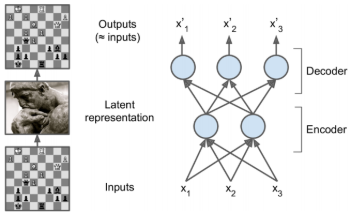

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-1.PNG']))
im

- autoencoder has similar architecture to Multi-Layer Perceptron (MLP)
- number of neurons in output layer must be equal to the number of inputs
- outputs are called ***reconstructions*** because the autoencoder tries to reconstruct the inputs
- the cost function contains a ***reconstruction loss*** that penalizes the model when the reconstructions differ from the inputs
---
- the internal representation has a lower dimensionality than the input data (2D instead of 3D), so the autoencoder is ***undercomplete***: 
 - forced to learn most important features in the input data and drop the unimportant ones

# Autoencoder for Dimensionality Reduction

- for an autoencoder to perform Principal Component Analysis (PCA): 
 - only uses linear activations and cost function is MSE

In [0]:
# 3D dataset
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

- a simple linear autoencoder to perform PCA on a 3D dataset (projecting it to 2D):

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

- number of outputs equal the number of inputs (3)
- for PCA, don't use any activation functions (all neurons are linear)
---
- training model on 3D dataset:

In [0]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 4ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [0]:
codings = encoder.predict(X_train)

array([[-1.4355531 ,  0.04288312],
       [ 0.25562766,  0.30128658],
       [-1.3182222 ,  0.06587002],
       [-0.88929987,  0.66199154],
       [-0.8249879 ,  0.610146  ],
       [ 1.0578617 , -0.5213433 ],
       [-1.5449699 ,  0.05390449],
       [ 0.30422845, -0.8063162 ],
       [ 1.0506717 , -0.23402442],
       [ 0.7862005 ,  0.07545842],
       [-1.0561181 ,  0.49125808],
       [ 1.1134902 , -0.69831294],
       [-1.2449077 ,  0.28120378],
       [-1.3697137 ,  0.09860038],
       [ 0.99625957, -0.73822534],
       [-0.18016787,  0.4527327 ],
       [ 0.33600977, -0.84704036],
       [ 0.9294085 ,  0.00763287],
       [ 0.5781009 , -0.8832273 ],
       [-1.394015  ,  0.05333451],
       [ 0.7075019 ,  0.17248935],
       [-1.3497142 , -0.17086232],
       [-1.0206424 ,  0.440997  ],
       [-1.3840228 ,  0.31660932],
       [ 1.0085891 , -0.7062139 ],
       [ 0.6046583 , -0.87926406],
       [-0.05950202,  0.5145448 ],
       [ 1.002238  , -0.6671876 ],
       [-0.9221158 ,

- same dataset used as both the inputs and targets
- the autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could (just like PCA):

Saving 17-2.PNG to 17-2.PNG


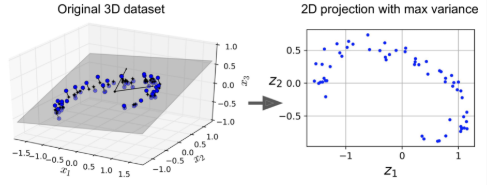

In [0]:
# PCA performed by an undercomplete linear autoencoder
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-2.PNG']))
im 

# Stacked Autoencoders

- autoencoders with multiple hidden layers (***stacked/deep autoencoders***)
- adding more layers helps the autoencoder learn more complex codings
- stacked encoder architecture is symmetrical with regard to the central hidden (coding) layer:

Saving 17-3.PNG to 17-3.PNG


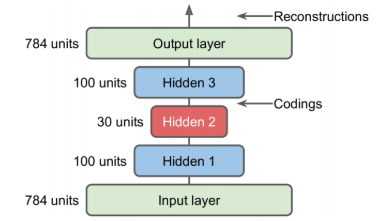

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-3.PNG']))
im 

- stacked autoencoder implementation very similar to deep MLP
- let's test on Fashion MNIST:

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9006
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2986 - val_rounded_accuracy: 0.9197
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

- split autoencoder into two submodels

**Encoder**:
- takes 28 x 28-pixel grayscale images and flattens them, so each image is represented as a vector of size 784
- vectors of size 784 go through two `Dense` layers of diminishing sizes (100 and then 30), both using SELU
- for each input image, encoder outputs a vector of size 30

**Decoder**:
- takes codings of size 30 and processes them through two `Dense` layers of increasing sizes (100 then 784), then reshapes the final vectors into 28 x 28 arrays so the decoder's outputs have the same shape as the encoder's inputs
- stacked autoencoders require the binary cross-entropy loss

## Visualizing the Reconstruction

- compare inputs and outputs to ensure autoencoder is properly trained

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


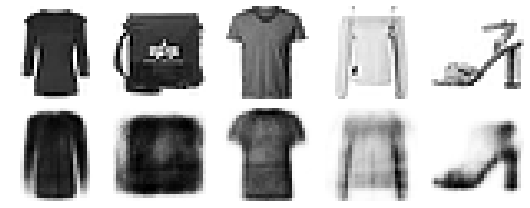

In [0]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")
# original images on top

- reconstructions are recognizable, but too lossy
- we need to train model for longer, deepen the model, or make codings larger
---
- avoid making the network too powerful, or it will simply make perfect reconstructions without actually learning any of the underlying patterns

## Stacked Autoencoders for Dimensionality Reduction

- autoencoders can handle large datasets with many instances and features
- one strategy is to use an autoencoder to reduce the dimensionality to a reasonable level, then use another dimensionality reduction algorithm for visualization
---
- first, we use stacked autoencoder to reduce dimensionality down to 30
- then, we use Scikit-Learn's implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization

In [0]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

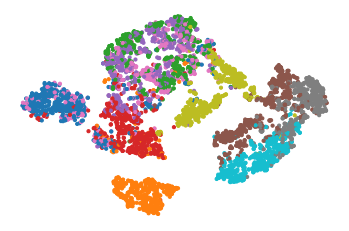

In [0]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


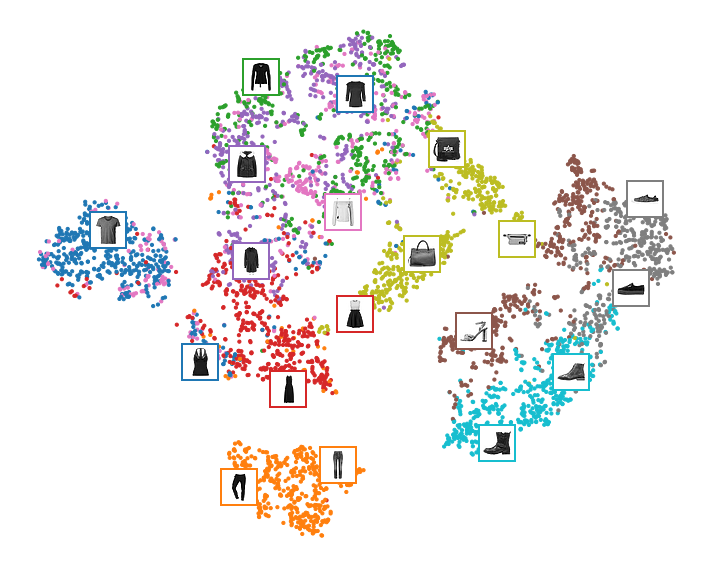

In [0]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

- t-SNE identified several clusters that accurately match the classes 


## Stacked Autoencoders for Unsupervised Pretraining

- if you don't have a lot of labeled training data, find a net that performs a similar task and reuse its lower layers (your net won't have to learn all the low-level features as it will just reuse the feature detectors learned by the pretrained net)
- similarly, if you have a large, mostly unlabeled dataset, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task and train it using the labeled data
- when training a classifier in this situation, you may want to freeze the pretrained layers

Saving 17-4.PNG to 17-4.PNG


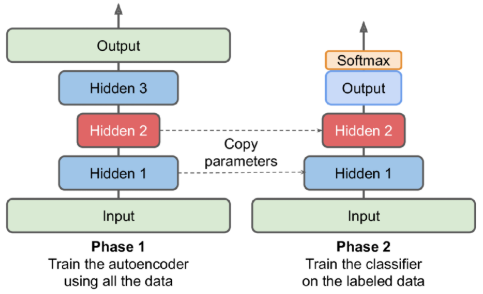

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-4.PNG']))
im 

## Tying Weights

- when aan autoencoder is symmetrical, it's common to ***tie*** the weights of the decoder layers to the weights of the encoder layers: 
 - this halves the number of weights, speeds up training, and helps alleviate overfitting
- to tie the weights between layers using Keras, we must define a custom layer:

In [0]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

- here, we are using the transpose of the encoder's weights as the decoder weights
- let's build a new stacked autoencoder, but with the decoder's `Dense` layers tied to the encoder's `Dense` layers:

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2920 - rounded_accuracy: 0.9275 - val_loss: 0.3018 - val_rounded_accuracy: 0.9085
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9324 - val_loss: 0.2874 - val_rounded_accuracy: 0.9314
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [==================

- this model achieves a lower reconstruction error with half the parameters

## Training Separate Parts of Stacked Autoencoders

- instead of training the entire stacked autoencoder at once, it's possible to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder: 
 - "greedy layerwise training"
- not a popular technique

Saving 17-5.PNG to 17-5.PNG


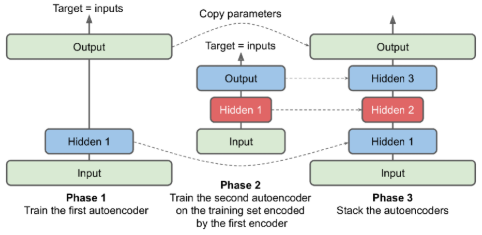

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-5.PNG']))
im 

**Phase 1**:
- first autoencoder learns to reconstruct the inputs: 
 - then we encode entire training set using this first autoencoder, which gives us a new, compressed training set

**Phase 2**:
- second autoencoder is trained on this new dataset

**Phase 3**:
- build big sandwich using all these autoencoders

# Convolutional Autoencoders

- if you want to build an autoencoder for images (for unsupervised pretraining or dimensionality reduction), you must build a ***convolutional autoencoder***: 
 - regular CNN composed of convolutional layers and pooling layers
 - reduces the spatial dimensionality of the inputs (height and width) while increasing the depth (number of feature maps)
 - the decoder does the reverse: upscales the images and reduces its depth back to original dimension
- here is a convolutional autoencoder for Fashion MNIST:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2848 - val_rounded_accuracy: 0.9287
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9454
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2708 - rounded_accuracy: 0.9461 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2671 - val_rounded_accuracy: 0.9509


In [0]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

# Recurrent Autoencoders

- to build an autoencoder for sequences, such as time series or text (for unsupervised pretraining or dimensionality reduction), build a ***recurrent autoencoder***
- the encoder is a sequence-to-vector RNN which compresses the input sequence to a single vector
- the decoder is a vector-to-sequence RNN which does the reverse

In [0]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [0]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3741 - val_rounded_accuracy: 0.8674
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3603 - val_rounded_accuracy: 0.8768
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3523 - val_rounded_accuracy: 0.8773
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3406 - rounded_accuracy: 0.8875 - val_loss: 0.3361 - val_rounded_accuracy: 0.8917
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3305 - val_rounded_accuracy: 0.8965
Epoch 7/10
1719/1719 [============

- this recurrent autoencodder can process sequences of any length
- we use a `RepeatVector` layer as the first layer of the decoder to ensure that its input vector gets fed to the decoder at each time step
---
**So Far**: 
- types of autoencoders: basic, stacked, convolutional, recurrent
- training methods: one shot, layer by layer
- applications: data visualization (dimensionality reduction), unsupervised pretraining
- in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete
---
**Next**:
- there are many other kinds of constraints that can be used, including ones that allow the coding layer to be just as large as the inputs, or even larger, resulting in an ***overcomplete autoencoder***

# Denoising Autoencoders

- another way to force the autoencoder to learn useful features is to add noise to its inputs, trianing it to recover the original, noise-free inputs: 
 - noise can be pure Gaussian noise, or randomly switched-off inputs (like dropout)
---
- implementation is simple: 
 - regular stacked autoencoder with an additional `Dropout` layer (or `GaussianNoise` layer) applied to the encoder's inputs
 - these noise layers are only applied during training
---
- using Gaussian noise:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3173 - val_rounded_accuracy: 0.9053
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9122
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

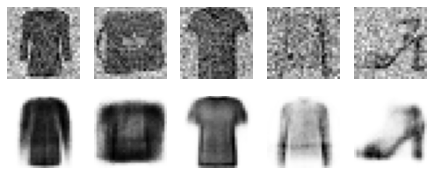

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

- using dropout:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9172
Epoch 7/10
1719/1719 [==================

Saving figure dropout_denoising_plot


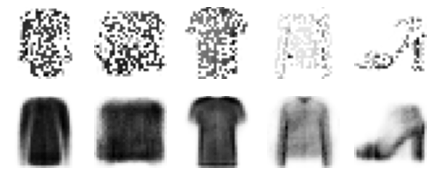

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

- as you can see, not only can denoising autoencoders be used for data visualization or unsupervised pretraining, like the other autoencoders we've discussed so far, but they can also be used to efficiently remove noise from images as well

# Sparse Autoencoders

- another constraint that leads to good feautre extraction is ***sparsity***: by adding an appropriate term to the cost function, the autoencoder is forced to reduce the number of active neurons in the coding layer: 
 - as a result, each neuron in the coding layers ends up representing a useful feature
---
- use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (with 300 units), and add some $l_1$ regularization to the coding layer's activations: 
 - the decoder is just a regular decoder

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

- let's implement a sparse autoencoder based on the KL divergence
- first, let's create a custom regularizer to apply KL divergence regularization:

In [0]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

# Variational Autoencoders (first glimpse at generative autoencoders)

- one of the most popular types of autoencoders
- quite different from the autoencoders we've discussed thus far:
 - they are ***probabilistic autoencoders***: their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which only use randomness during training)
 - most importantly, they are ***generative autoencoders***: they can generate new instances that look like they were sampled from the training set

Saving 17-6.PNG to 17-6.PNG


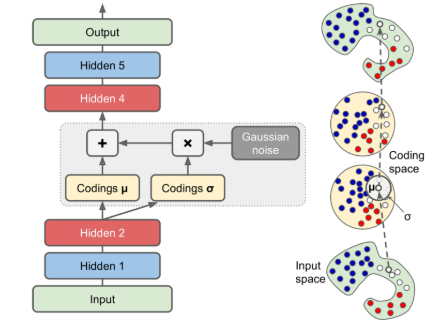

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-6.PNG']))
im 

- left: variational autoencoder
- right: instance going through it
---
**How it Works**: 
- twist: instead of directly producing a coding for a given input, the encoder produces a ***mean coding*** and a standard deviation:
 - the actual coding is then sampled randomly from a Gaussian distribution with the mean and standard deviation
- after the "twist", the decoder decodes the sampled coding normally
---
**Generating a New Instance**:
- after training a variational autoencoder, you can easily generate a new instance: 
 - just sample a random coding from the Gaussian distribution, decode it, and voilà
---
**Special Cost Function**: 
- composed of two parts: 
 - first is the standard reconstruction loss that pushes the autoencoder to reproduce its inputs (binary cross entropy)
 - second is the ***latent loss*** that pushes the autoencoder to have codings that look as though they were sampled from a Gaussian distribution
---
**Implementation**:
 - let's start by building a variational autoencoder for Fashion MNIST: 
  - first, we need a custom layer to sample the codings


In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

- takes two inputs: `mean` and `log_var`
- this samples a codings vector from the Normal distribution with the mean and standard deviation
---
- next, let's create the encoder using the Functional API as the model is not entirely sequential

**The Encoder**:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

- the `Dense` layers that output `codings_mean` and `codings_log_var` have the same inputs
- then pass both `codings_mean` and `codings_log_var` to the `Sampling` layer
- finally, the `variational_encoder` model has three outputs: 
 - `codings_mean` and `codings_log_var` (in case you want to inspect these values)
 - most importantly, `codings` (the only output we use)
---
**The Decoder**: 

In [0]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

- virtually identical to many of the decodes we've built so far (so the Sequential API would have been fine here as oppose to the functional API)
---
**The Variational Autoencoder Model**:

In [0]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

- we ignore the first two outputs of the encoder (as discussed above) as we only want to feed the actual codings to the decoder
---
**Latent Loss and Reconstruction Loss**:

In [0]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy]) 

- we first compute the latent loss for each instance in the batch and sum over the last axis
- then we compute the mean loss over all the instances in the batch and divide the result by 784 to ensure it has the appropriate scale compared to the reconstruction loss: 
 - when Keras computes the `"binary_crossentropy"` loss, it computes the mean over all 784 pixels rather than the sum
 - this means that the reconstruction loss is 784 times smaller than we need it to be
---
**Training the Autoencoder**:
- still on Fashion MNIST
- still using the `rounded_accuracy` metric we defined way above

In [0]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3893 - rounded_accuracy: 0.8611 - val_loss: 0.3536 - val_rounded_accuracy: 0.8853
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3424 - rounded_accuracy: 0.8981 - val_loss: 0.3350 - val_rounded_accuracy: 0.9061
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3326 - rounded_accuracy: 0.9054 - val_loss: 0.3315 - val_rounded_accuracy: 0.9088
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3278 - rounded_accuracy: 0.9094 - val_loss: 0.3292 - val_rounded_accuracy: 0.9059
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3247 - rounded_accuracy: 0.9118 - val_loss: 0.3292 - val_rounded_accuracy: 0.9100
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3225 - rounded_accuracy: 0.9137 - val_loss: 0.3246 - val_rounded_accuracy: 0.9108
Epoch 7/25
430/430 [==============================] 

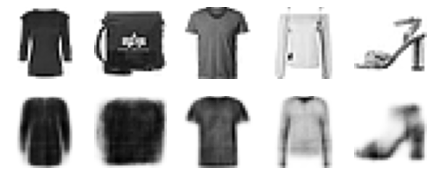

In [0]:
show_reconstructions(variational_ae)
plt.show()

## Generating New Instances

- now, let's use this variational autoencoder to generate images that look like fashion items: 
 - sample random codings from a Gaussian distribution and decode them

In [0]:
# for visualization purposes
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [0]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

Saving figure vae_generated_images_plot


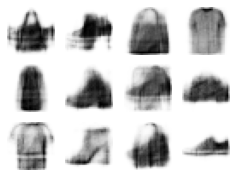

In [0]:
# visualizing the generated fashion items
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

- some of these images are convincing, but many are too fuzzy or bad
- for improved results, give the model more fine-tuning and training time
---
- variational autoencoders allow for ***semantic interpolation***: instead of interpolating two images at the pixel level (which would look as if the two images were overlaid), we can interpolate at the coding level
 - first, run both images through encoder
 - second, interpolate the resulting two codings
 - finally, decode the interpolated codings to produce final image
- for example, we take the 12 codings we just generated, organize them in a 3 x 4 grid, then use `tf.image.resize()` to resize this grid to 5 x 7:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

- let's visualize the resulting images:

Saving figure semantic_interpolation_plot


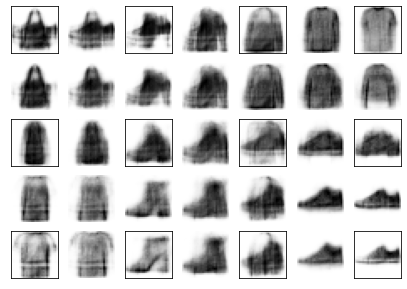

In [0]:
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

- for several years, variational autoencoders were popular, but GANs eventually took the lead, primarily because they are capable of generating much more realistic and crisp images

# Generative Adversial Networks

**Overview**:
- make neural networks compete against each other to push them both to excel
- GANs are composed of two neural networks:
 - ***generator***: takes random distribution (latent representations/codings) as input and outputs some data (images) | same functionality as decoder in a variational autoencoder --> can be used in the same way to generate new images
 - ***discriminator***: takes either a fake image from the generator or a real image from the training set as input, and must guess whether the input image is fake or real

Saving 17-7.PNG to 17-7.PNG


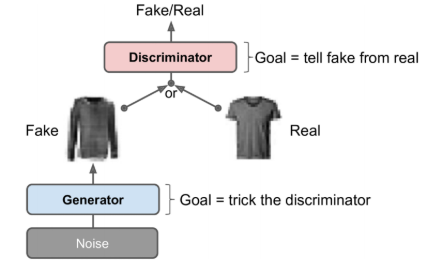

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17-7.PNG']))
im 

**Training**: 
- during training, the generator and the discriminator have opposite goals, therefore, each training iteration is divided into two phases:
 - **Phase 1**: we train the discriminator --> a batch of real images is sampled from the training set, along with a batch of fake images produced by the generator --> the real images are labeled (1) and the fake images are labeled (0) --> the discriminator is trained on this collective, labeled batch for one step using binary cross-entropy loss --> importantly, backpropagation only optimizes the weights of the discriminator in this phase
 - **Phase 2**: we train the generator --> first use it to produce another batch of fake images --> once again, the discriminator is used to tell whether the images are real or fake --> but this time, we do not add real images in the batch and all labels are set to 1 (real) as to trick the discriminator (so it can learn) --> importantly, the weights of the discriminator are frozen during this step, so backpropagation only affects the weights of the generator
---
- the generator never actually sees real images, though it gradually learns how to produce convincing fake ones: 
 - all it gets is the gradients flowing back through the discriminator
- the better the discriminator gets, the more information about the real images is contained in these secondhand gradients, so the generator can make significant progress
---
- let's build a simple GAN for Fashion MNIST: 
 - generator resembles an autoencoder's decoder
 - discriminator is a regular binary classifier (takes an input image and ends with a `Dense` layer containing a single unit, using the sigmoid activation function) 

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

- next, we need to compile these models
- as the discriminator is a binary classifier, we can naturally use the binary cross-entropy loss
- the generator will only be trained through the `gan` model, so we do not need to compile it at all: 
 - the `gan` model is also a binary classifier, so we can use the binary cross-entropy loss as well
- importantly, the discriminator should not be trained during the second phase, so we make it non-trainable before compiling the `gan` model

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

- after running this code, the `discriminator` is trainable if we call its `fit()` or its `train_on_batch()`, while it is not trainable when we call these methods on the collective `gan` model
---
- this is not a standard training loop, so we cannot use the regular `fit()` method: 
 - instead, we will write a custom training loop --> first, we need to create a `Dataset` to iterate through the images

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

- now let's write the custom loop:

In [0]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

- **Phase 1**: we feed the Gaussian noise to the generator to produce fake images and we complete this batch by concatenating an equal number of real images (fakes labeled 0, reals labeled 1) --> then we train the discriminator on this batch (we set discriminator's `trainable` attribute to `True`)
- **Phase 2**: we feed the GAN some Gaussian noise --> its generator will start producing fake images, then the discriminator will try to guess whether these images are real or fake --> we want the discriminator to believe that these fake images are real --> we set the discriminator's `trainable` attribute to `False`

In [0]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


- let's just say, the results were not too good: this is because training a GAN is difficult

## The Difficulties of Training GANs

- during training, the generator and discriminator constantly try to outsmart each other
- as training advances, the game may end in a state called ***Nash equilibrium***, where no competitor would be better off changing their own strategy
- a GAN can only reach a single Nash equilibrium: 
 - this is when the generator produces perfectly realistic images and the discriminator is forced to make 50/50 guesses, however, nothing guarantees that this equilibrium will ever be reached
---
- the biggest difficulty is called ***mode collapse***: when the generator's outputs gradually become less diverse
 - for example, the generator could get better at producing convincing shoes than any other class --> it fools the discriminator a lot with shoes, which encourages it to produce even more fake images of shoes --> gradually, the discriminator forgets how to produce anything else --> meanwhile, the discriminator will only see fake shoes, so it will also forget how to discriminate fake images of anything else --> this horrible cycles repeats with other classes, never gaining a permanent hold at any of them
---
- moreover, because the generator and discriminator are constantly pushing against each other, their parameters may end up oscillating and becoming unstable 
- GANs are very sensetive to hyperparameters: you have to spend a lot of time fine-tuning them

## Deep Convolutional GANs

- here are some guidlines proposed for building stable convolutional GANs: 
 - replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator)
 - use Batch Normalization in both the generator (except in output layer) and the discriminator (except in input layer)
 - remove fully connected hidden layers for deeper architectures
 - use ReLU activation in the generator for all layers except the output layer, which should use tanh
 - use leaky ReLU activation in the discriminator for all layers
---
- these are good guidlines, but won't work in every case
- here is a small DCGAN that works reasonably well for Fashion MNIST:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

- generator takes codings of size 100, and projects them to 6272 dimensions (7 * 7 * 128), and reshapes the result to get a 7 x 7 x 128 tensor: 
 - this tensor is batch normalized and fed to a transposed convolutional layer with a stride of 2, which upsamples it from 7 x 7 to 14 x 14 and reduces its depth from 128 to 64
- the result is batch normalized again and fed to another transposed convolutional layer with a stride of 2, which unsamples it from 14 x 14 to 28 x 28 and reduces the depth from 64 to 1: 
 - this layer uses the tanh activation function, so the outputs will range from -1 to 1 --> for this reason, before training the GAN, we need to rescale the training set to that same range
 - we also need to reshape it to add the channel dimension

In [0]:
# reshape and rescale (due to tanh in the generator's output layer)
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 

- the discriminator looks much like a regular CNN for binary classification, except instead of usiung max pooling layers to downsample the image, we use strided convolutions (`strides=2`) --> we also use the leaky ReLU activation function
---
- for the most part, we respected the DCGAN guidlines, except we replaced the `BatchNormalization` layers in the discriminator with `Dropout` layers (otherwise training was unstable) and we replaced ReLU with SELU in the generator

In [0]:
# for visualization purposes
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()  

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
train_gan(gan, dataset, batch_size, codings_size)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

- for each of these categories, the codings that were used to generate the images were averaged, and an image was generated based on the resulting mean codings
- you can control the class of each image produced by the generator (***conditional GANs***)

# Exercises

*1) What are the main tasks that autoencoders are used for?*

*2) Suppose you want to train a classifier, and you have plenty of unlabeled training data but only a few thousand labeled instances. How can autoencoders help? How would you procede?*

*3) If an autoencoder perfectly reconstructs the inputs, is it necessarily a good autoencoder?*

*4) What are undercomplete and overcomplete autoencoders? What is the main risk of an excessively undercomplete autoencoder? What about the main risk of an overcomplete autoencoder?* 

*5) How do you tie weights in a stacked autoencoder? What is the point of doing so?*

*6) What is a generative model? Can you name a type of generative autoencoder?*

*7) What is a GAN? Can you name a few tasks where GANs can shine?*

*8) What are the main difficulties when training GANs?*

1) feature extraction, unsupervised pretraining, dimensionality reduction, generative models, anomaly detection

2) you could first train a deep autoencoder on the fulldataset (labeled + unlabeled), then reuse its lower half for the classifier (the layers up to the codings layer, included) and train the classifier using the labeled data: 
 - if you have littled labeled data, you want to freeze the reused layers when training the classifer

3) no, it could just be an overcomplete autoencoder that simply learned to copy its inputs to the codings layer and then to the outputs: 
 - doing so without actually learning the patterns
 - one way to evaluate an autocoder uis to measure its reconstruction loss using MSE
 - high MSE is bad, but a low MSE does not necessarily mean the autoencoder is good

4) an undercomplete autoencoder is one whose codings layer is smaller than the input and output layers: 
 - if the codings layer is larger, then it's an overcomplete autoencoder
 - undercomplete autoencoders can fail to reconstruct the inputs, while overcomplete autoencoders fall victim to simplying copying the inputs without actually learning any of the underlying patterns

5) make the decoder weights equal to the transpose of the encoder weights, which reduces the number of parameters of the model by half: 
 - this speeds up training and reduces the risk of overfitting

6) generative autoencoders can randomly generate outputs that resemble the training instances: 
 - for example, a variational autoencoder

7) a generative adversial network is a neural network architecture composed of two parts, a generator and a discriminator, which have opposing objectives: 
 - the generator's goal is to generate instances similar to those of the training set, which it uses to try to fool the discriminator
 - the discriminator must distinguish the real instances from the fake, generated ones
 - at each training iteration, the discriminator is trained like a normal binary classifier, then the generator is trained to maximize the discriminator's error
 - GANs are used for advanced image processing, data augmentation, to generate other types of data, and to identify the weaknesses in other models in an attempt to strengthen them

8) complex dynamics between the generator and the discriminator cause a lot of problems: 
 - biggest difficulty is mode collapse, where the generator produces outputs with little diversity
 - GANs are extremely sensetive to hyperparameter tuning
 - training can go horribly wrong at any given instant for no apparent reason